In [1]:
options(tidyverse.quiet = TRUE) 
library(tidyverse, warn.conflicts = FALSE)

library(badr)
load_julia_package()

Loaded julia package 'bad' successfully.



# Finding Optimal Two-Stage Designs

## Optimal Two-Stage Designs

### Optimal vs Simons, unimodality

Start by defining the standard parameters and recovering Simon's optimal design as reference.

In [2]:
alpha <- .05 # maximal type one error rate
beta  <- .2  # maximal type two error rate
p0    <- .2  # boundary of the null hypothesis H0: p <= p0
p1    <- .4  # point alternative to power on

design_simon <- Design(
    c(rep(0, 4), rep(30, 10)),
    c(rep(Inf, 4), rep(12, 10) - seq(4, 13)),
    label = "Simon's"
)

Next define the optimisation problem for minimising the expected sample size on the boundary of the null hypothesis.

In [3]:
design_optimal <- Problem(
        minimise(SampleSize(PointMass(p0))),
        Power(PointMass(p0)) <= alpha,
        Power(PointMass(p1)) >= 1 - beta,
        label = 'optimal'
    ) %>%
    optimise_design(verbosity = 0)

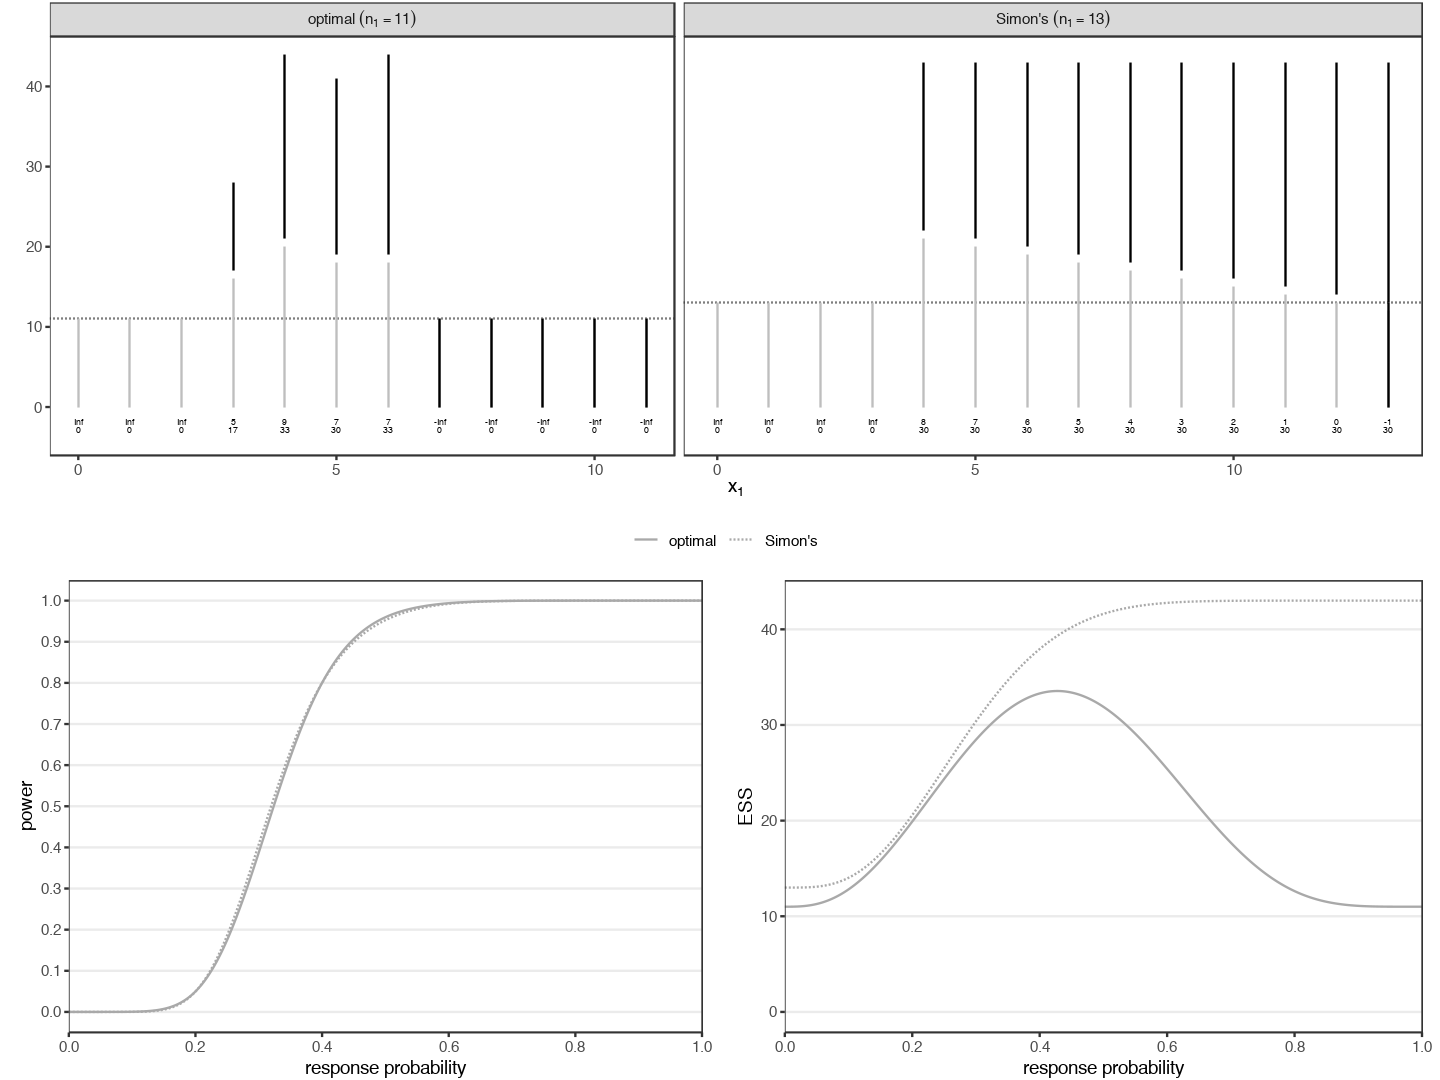

In [4]:
options(repr.plot.width = 12, repr.plot.height = 9)

plot_compare_designs(design_simon, design_optimal)

Evidently, the optimal design is not unimodal - explicitly require unimodality and compare again!

In [5]:
design_optimal_unimodal <- Problem(
        minimise(SampleSize(PointMass(p0))),
        Power(PointMass(p0)) <= alpha,
        Power(PointMass(p1)) >= 1 - beta,
        label = 'optimal, unimodal',
        unimodal = TRUE,
        n1values = 5:20 # we already know roughly where the optimum lies!
    ) %>%
    optimise_design(verbosity = 0)

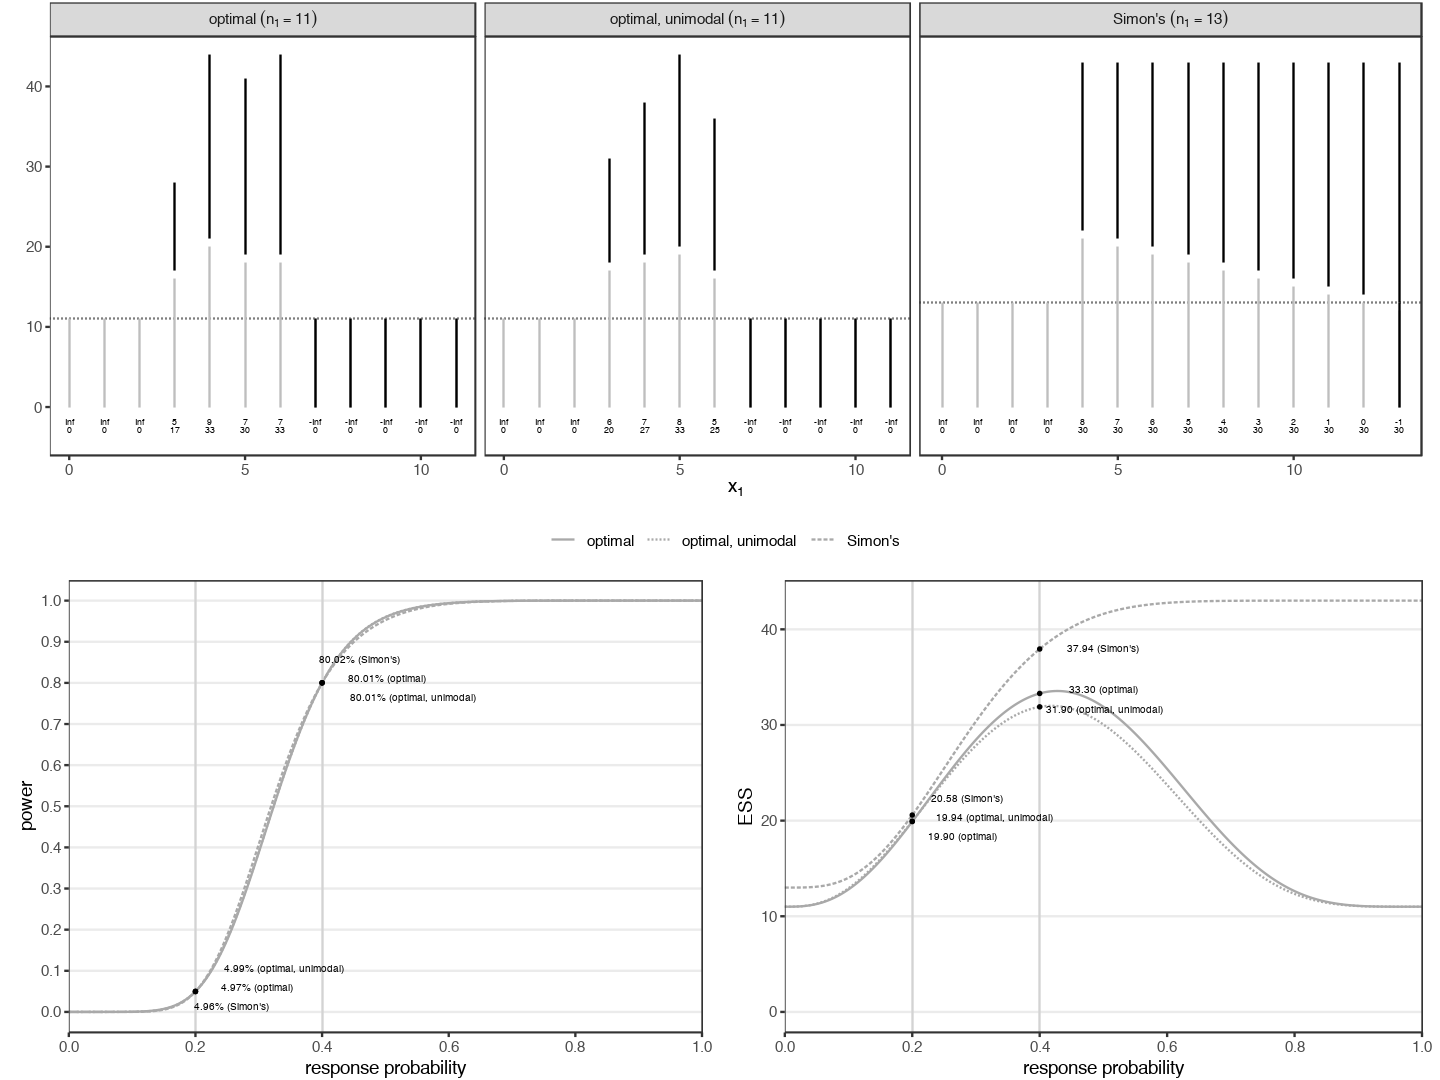

In [6]:
options(repr.plot.width = 12, repr.plot.height = 9)

plot_compare_designs(
    design_simon, design_optimal, design_optimal_unimodal,
    annotations = c(p0, p1)
)

In [7]:
ggsave("optimal-two-stage-designs-simons-vs-optimal.pdf", width = 7, height = 7)

### Optimal under null vs optimal under alternative vs minimax

In [8]:
design_optimal_alternative <- Problem(
        minimise(SampleSize(PointMass(p1))),
        Power(PointMass(p0)) <= alpha,
        Power(PointMass(p1)) >= 1 - beta,
        label = 'alternative'
    ) %>%
    optimise_design(verbosity = 0)

In [9]:
design_minimax <- Problem(
        minimise_maximal_sample_size(.2, PointMass(p0)),
        Power(PointMass(p0)) <= alpha,
        Power(PointMass(p1)) >= 1 - beta,
        nmax = 35, # cannot be more than fixed size test!
        label = 'minimax'
    ) %>%
    optimise_design(verbosity = 0)

In [10]:
design_optimal_unimodal@label <- 'null'

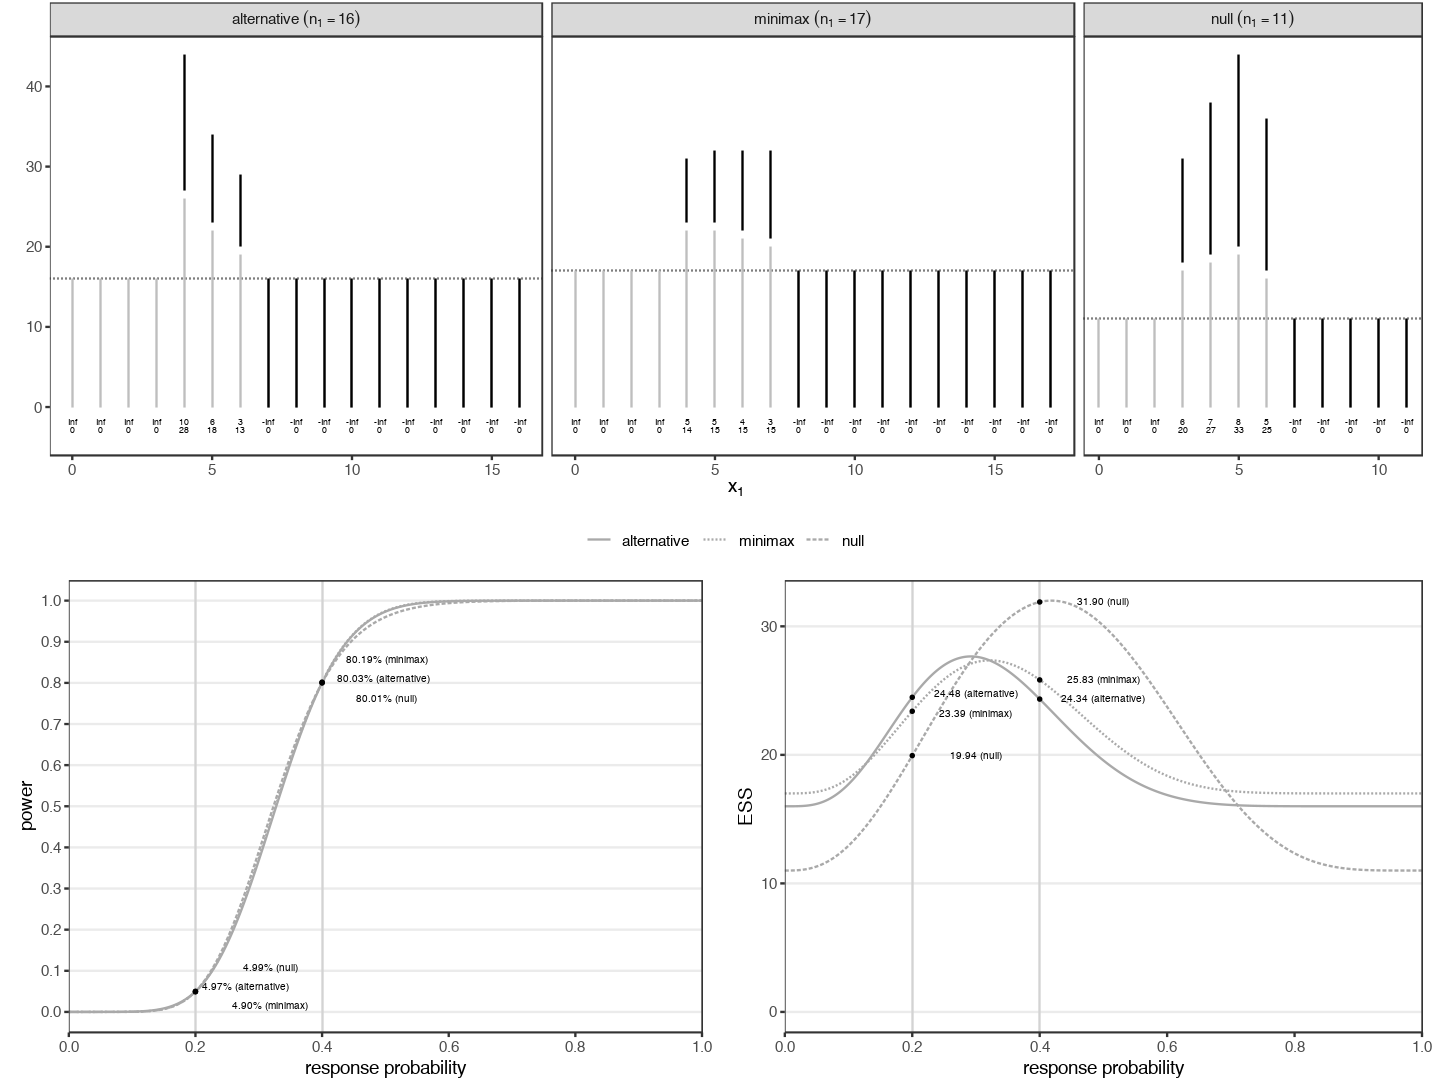

In [11]:
options(repr.plot.width = 12, repr.plot.height = 9)

plot_compare_designs(
    design_optimal_unimodal, design_optimal_alternative, design_minimax,
    annotations = c(p0, p1)
)

In [12]:
ggsave("optimal-two-stage-designs-null-vs-alternative-vs-minimax.pdf", width = 7, height = 7)

### Solution time

In [13]:
get_design <- function(p1) {
    cat(sprintf("%s: p1 = %.2f\n\r", Sys.time(), p1))
    Problem(
        minimise(SampleSize(PointMass(p0))),
        Power(PointMass(p0)) <= alpha,
        Power(PointMass(p1)) >= 1 - beta,
        maxmultipleonestage = 1.5,
        nmax = 200
    ) %>%
    optimise_design()
}

In [14]:
# warm up, juia needs to precompile
dummy_ <- get_design(.5)

# compute optimal designs for varying difference of p0 and p1
tbl_designs <- tibble(
    p1     = seq(.5, .3, by = -.01),
    design = map(p1, get_design)
)

2020-01-21 22:33:59: p1 = 0.50
2020-01-21 22:34:03: p1 = 0.50
2020-01-21 22:34:06: p1 = 0.49
2020-01-21 22:34:10: p1 = 0.48
2020-01-21 22:34:14: p1 = 0.47
2020-01-21 22:34:19: p1 = 0.46
2020-01-21 22:34:25: p1 = 0.45
2020-01-21 22:34:31: p1 = 0.44
2020-01-21 22:34:38: p1 = 0.43
2020-01-21 22:34:50: p1 = 0.42
2020-01-21 22:35:05: p1 = 0.41
2020-01-21 22:35:22: p1 = 0.40
2020-01-21 22:35:42: p1 = 0.39
2020-01-21 22:36:13: p1 = 0.38
2020-01-21 22:36:57: p1 = 0.37
2020-01-21 22:38:02: p1 = 0.36
2020-01-21 22:39:24: p1 = 0.35
2020-01-21 22:41:25: p1 = 0.34
2020-01-21 23:14:02: p1 = 0.33
2020-01-22 00:06:54: p1 = 0.32
2020-01-22 00:08:56: p1 = 0.31
2020-01-22 00:14:00: p1 = 0.30


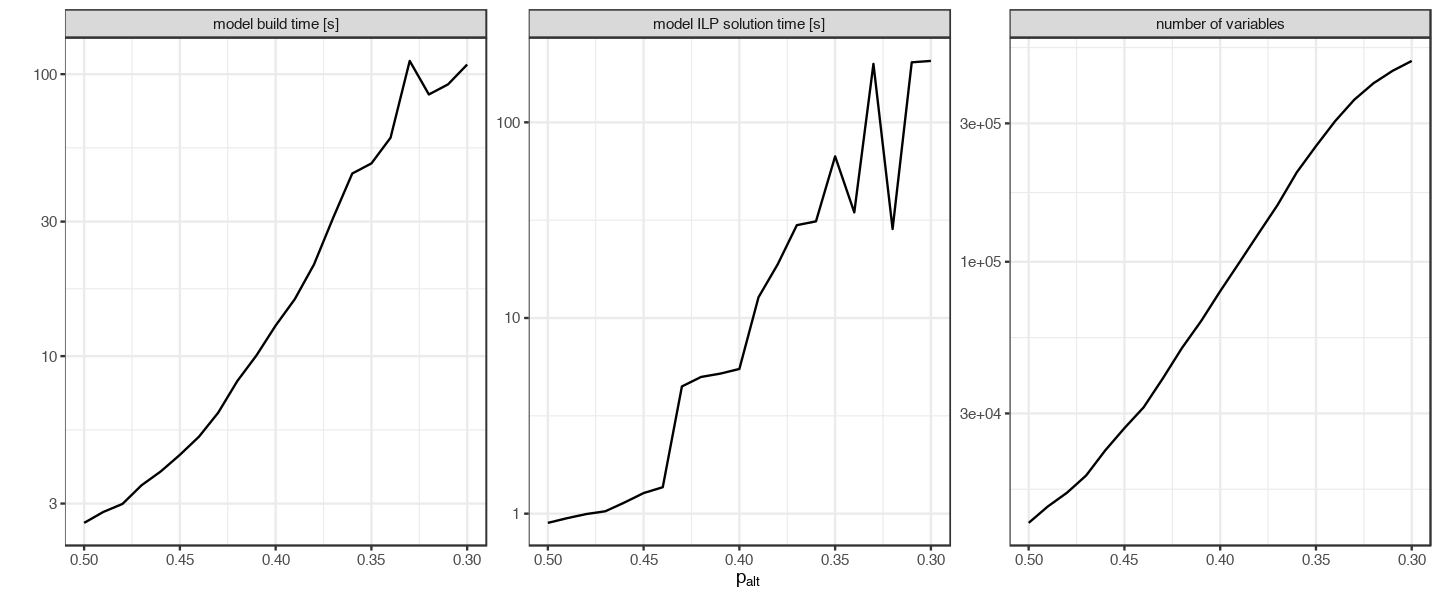

In [15]:
options(repr.plot.width = 12, repr.plot.height = 5)

tbl_designs %>%
    mutate(
        info = map(design, ~as_tibble(JuliaCall::field(.@jdesign, 'info')))
    ) %>%
    unnest(info) %>%
    select(
        -design, -`MLE-compatible`, -`solution extraction time [s]`, -`total time [s]`
    ) %>%
    pivot_longer(-p1) %>%
    ggplot() +
        aes(p1, value) +
        geom_line() +
        facet_wrap(~name, scales = 'free_y', nrow = 1) +
        scale_y_log10('') +
        scale_x_reverse(expression(p[alt])) +
        theme_bw()

In [16]:
ggsave("optimal-two-stage-designs-solution-speed.pdf", width = 7, height = 3)